In [6]:
import sys
sys.path.append('..')

import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling, diagnostic, tworound_potts

import pickle

import tworound_potts

In [7]:
experiment_id_idx = 0
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
experiment_id = experiment_ids[experiment_id_idx]
round_ids = ["ARN", "R01", "R02N"]

In [8]:
dtype = torch.float32
device = torch.device('cpu')

In [9]:
sequences, sequences_unique, counts, log_multinomial_factors = utils.sequences_counts_from_files(experiment_id, round_ids)

Finished round ARN
Finished round R01
Finished round R02N


In [64]:
sequences_oh = [utils.one_hot(s) for s in sequences]
total_reads = torch.tensor([len(s) for s in sequences]).to(device)

In [34]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/Users/scrotti/Aptamer2025py/experiments/../callback.py'>

In [112]:
L, q = 45, 4
h = torch.randn(L, q, dtype=dtype)
k = torch.randn(L, q, dtype=dtype)
J = utils.rand_coupling_matrix(L, q, dtype=dtype)

In [200]:
chempot = 2.3

tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)
chemical_potentials = torch.ones(selected_modes.size()) * chempot

potts = energy_models.Potts(J, h.clone() + chempot/L)
Ns0 = energy_models.IndepSites(k)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model1 = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

potts = energy_models.Potts(J, h.clone())
Ns0 = energy_models.IndepSites(k)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model2 = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes, chemical_potentials=chemical_potentials).to(device)

In [201]:
X = sequences_oh[0][:1000]

In [202]:
logps1 = model1.selection_energy_at_round(X, 2)

In [203]:
logps2 = model2.selection_energy_at_round(X, 2)

In [204]:
(logps1 - logps2).abs().max()

tensor(3.5763e-06, grad_fn=<MaxBackward1>)

In [205]:
n_chains = 10**3
n_sweeps = 1
step = 1e-4

In [206]:
def estimate_nll_potts(sequences_oh, model, total_reads, log_multinomial_factors, n_chains, n_sweeps, step):
    batches = sequences_oh
    nll_potts = - training.estimate_log_likelihood_AIS(model, batches, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)
    return nll_potts

In [208]:
nll1 = estimate_nll_potts(sequences_oh, model1, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)

  0%|      | 0/10000 [00:00<?, ?it/s]

  0%|      | 0/10000 [00:00<?, ?it/s]

  0%|      | 0/10000 [00:00<?, ?it/s]

In [209]:
nll2 = estimate_nll_potts(sequences_oh, model2, total_reads, log_multinomial_factors, n_chains, n_sweeps, step)

  0%|      | 0/10000 [00:00<?, ?it/s]

  0%|      | 0/10000 [00:00<?, ?it/s]

  0%|      | 0/10000 [00:00<?, ?it/s]

In [210]:
nll1, nll2

(21.230274200439453, 21.077232360839844)

In [179]:
model_indep = torch.load(f'saved/{experiment_id}_indep_sites.pt', weights_only=False, map_location='cpu')
k_indep = model_indep.round_zero.set_zerosum_gauge().h.detach().clone()
h_indep = model_indep.selection.modes[0].set_zerosum_gauge().h.detach().clone()

In [180]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/Users/scrotti/Aptamer2025py/experiments/../callback.py'>

In [190]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
k = k_indep.clone()
# h = torch.zeros(L, q, dtype=dtype)
h = h_indep.clone()
J = torch.zeros(L, q, L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes, learn_chemical_potentials=False).to(device)

In [191]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [192]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [193]:
weight_decay = 0.0
lr = 0.1

optimizer = torch.optim.SGD([
    {'params': (model.round_zero.h), 'lr': 10*lr},
    {'params': (model.selection.modes[0].J,), 'weight_decay': weight_decay},
    {'params': (model.selection.modes[0].h,)}
], lr=lr, weight_decay=0.0)

In [194]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             callback.ParamsCallback(save_every=1),
            ]

In [195]:
n_sweeps = 10
max_epochs = 1000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               optimizer=optimizer, callbacks=callbacks, log_weights=log_weights,
               log_multinomial_factors=log_multinomial_factors)

 0.00%[ ] Epoch: 0/1000 [00:00<?, ?it

KeyboardInterrupt: 

(<Figure size 1200x300 with 4 Axes>,
 array([<Axes: xlabel='iter', ylabel='|1-pearson|'>,
        <Axes: xlabel='iter', ylabel='|1-slope|'>, <Axes: xlabel='iter'>,
        <Axes: xlabel='iter', ylabel='NLL'>], dtype=object))

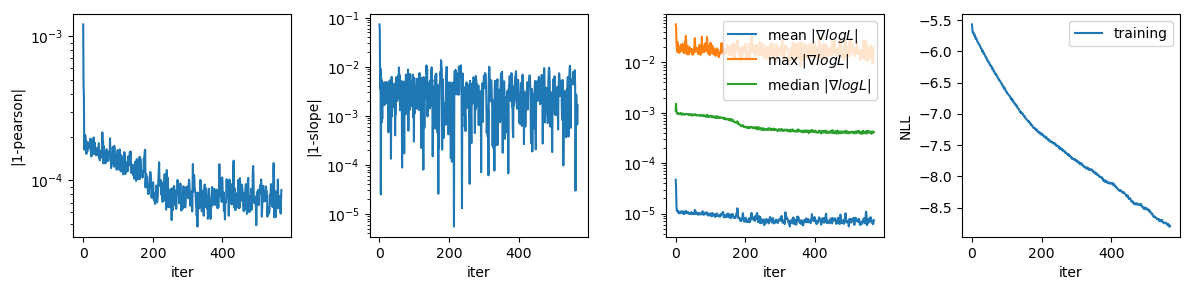

In [196]:
callbacks[0].plot()

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Pearson $C_{ij}$ Ns0'}, xlabel='iter', ylabel='$|1-\\rho|$'>,
        <Axes: title={'center': 'Pearson $C_{ij}$ ps'}, xlabel='iter', ylabel='$|1-\\rho|$'>],
       dtype=object))

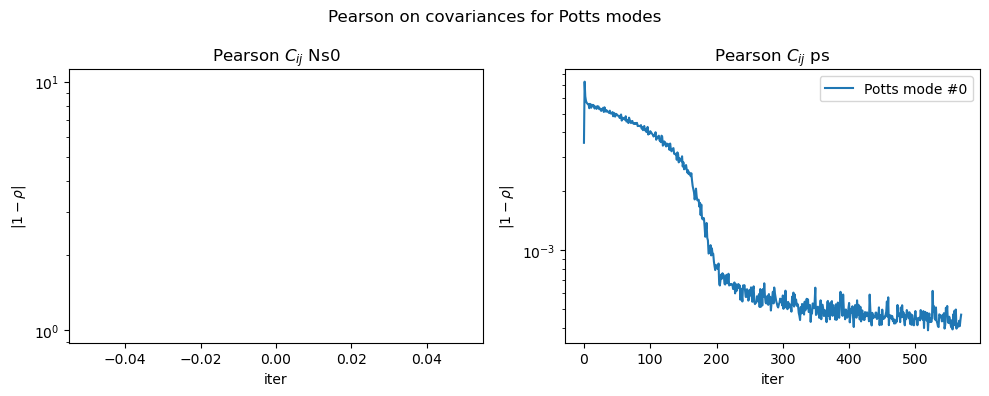

In [197]:
callbacks[1].plot()

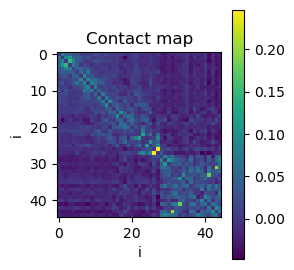

In [198]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge()
J = potts_zerosum.J.detach().cpu()
h = potts_zerosum.h.detach().cpu()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
plt.title('Contact map');

In [199]:
model.chemical_potentials

tensor([[0.],
        [0.]])